In [6]:
# MOD per system
import sys
sys.path.append('C:/Users/emiga/OneDrive/Cal/GWs/code/holodeck')


# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

In [7]:
def gws_by_loops(edges, number, realize, sum = False, printr = True):
       
    """ Inefficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If an `int` value, then how many discrete realizations to construct.
    sum : bool
        Whether or not to sum the strain at a given frequency over all bins.


    Returns
    -------
    hc : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False, sum = False: shape is (M-1, Q-1, Z-1, F-1)
        realize = True or False, sum = True: shape is (F-1)
        realize = R, sum = False: shape is  (M-1, Q-1, Z-1, F-1, R)
        realize = R, sum = True: shape is  (F-1, R)

    """
    
    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift

    # make strain grid
    hc_grid = np.empty_like(number)

    # for r realizations, make a grid with shape 
    # m, q, z, f, r
    if(utils.isinteger(realize)):
        newshape = hc_grid.shape + (realize,)
        realized_grid = np.empty(newshape)

    # get strain for each bin
    for m_idx in range(len(mt)):
        if(printr): print('mass %d' % m_idx)
        for q_idx in range(len(mr)):
            for z_idx in range(len(rz)):
                cmass = holo.utils.chirp_mass_mtmr(mt[m_idx], mr[q_idx])
                cdist = holo.cosmo.comoving_distance(rz[z_idx]).cgs.value
                

                for f_idx in range(len(fc)):
                    rfreq = holo.utils.frst_from_fobs(fc[f_idx], rz[z_idx])
                    hs_mqzf = utils.gw_strain_source(cmass, cdist, rfreq)
                    hc_dlnf = hs_mqzf**2 * (fc[f_idx]/df[f_idx])
                    
                    if(realize == False):
                        hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        * number[m_idx, q_idx, z_idx, f_idx])
                    elif(realize == True):
                        hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        *np.random.poisson(number[m_idx, q_idx, z_idx, f_idx]))
                    elif(utils.isinteger(realize)):
                        for r_idx in range(realize):
                            realized_grid[m_idx, q_idx, z_idx, f_idx, r_idx] = \
                                np.sqrt(hc_dlnf 
                                        *np.random.poisson(number[m_idx, q_idx, z_idx, f_idx]))
                        hc_grid = realized_grid                
                    else:
                        print("`realize` ({}) must be one of {{True, False, integer}}!"\
                            .format(realize))
   
    if(sum):
        # sum over all bins at a given frequency and realization
        hc_grid = np.sqrt(np.sum(hc_grid**2, axis=(0, 1, 2)))

    return hc_grid


# Example

### Choose the frequency bins at which to calculate the GWB
same as in semi-analytic-models.ipynb

In [8]:
fobs = utils.nyquist_freqs(10.0*YR, 0.2*YR)
fobs_edges = utils.nyquist_freqs_edges(10.0*YR, 0.2*YR)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 24
  between [0.10, 2.50] 1/yr
          [3.17, 79.22] nHz


### Build Semi-Analytic-Model with default (or fewer) parameters 

In [9]:
# sam = holo.sam.Semi_Analytic_Model()
sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), 
                            mrat=(1e-3, 1.0, 15), redz=(1e-3, 10.0, 25))
print('edges:', sam.edges)

edges: [array([1.98840987e+37, 4.64437162e+37, 1.08479585e+38, 2.53378096e+38,
       5.91820659e+38, 1.38232822e+39, 3.22873370e+39, 7.54142261e+39,
       1.76146627e+40, 4.11429458e+40, 9.60984619e+40, 2.24459241e+41,
       5.24274267e+41, 1.22455866e+42, 2.86022796e+42, 6.68069584e+42,
       1.56042447e+43, 3.64471694e+43, 8.51304360e+43, 1.98840987e+44]), array([0.001     , 0.00163789, 0.0026827 , 0.00439397, 0.00719686,
       0.01178769, 0.01930698, 0.03162278, 0.05179475, 0.08483429,
       0.13894955, 0.22758459, 0.37275937, 0.61054023, 1.        ]), array([1.00000000e-03, 1.46779927e-03, 2.15443469e-03, 3.16227766e-03,
       4.64158883e-03, 6.81292069e-03, 1.00000000e-02, 1.46779927e-02,
       2.15443469e-02, 3.16227766e-02, 4.64158883e-02, 6.81292069e-02,
       1.00000000e-01, 1.46779927e-01, 2.15443469e-01, 3.16227766e-01,
       4.64158883e-01, 6.81292069e-01, 1.00000000e+00, 1.46779927e+00,
       2.15443469e+00, 3.16227766e+00, 4.64158883e+00, 6.81292069e+00,
      

### Get SAM edges and numbers as in sam.gwb()

In [11]:
# get observed orbital frequency bin edges and centers 
# from observed GW frequency bin edges
# f_orb = f_GW/2
fobs_orb_edges = fobs_edges / 2.0
fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

# dynamic_binary_number
# gets differential number of binaries per bin-vol per log freq interval
edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents)
edges[-1] = fobs_orb_edges

# integrate (multiply by bin volume) within each bin
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges))

### If on desktop: Calculate strain by both methods
1) Using gravwaves._gws_from_number_grid_integrated()
2) Using gws_by_loops() (above)

In [69]:
# # get GWB spectrum using gravwaves._gws_from_number_grid_integrated()

# # without sampling
hc_samF = holo.gravwaves._gws_from_number_grid_integrated(edges, number, realize=False, sum=False) 
hc_samF_sum = holo.gravwaves._gws_from_number_grid_integrated(edges, number, realize=False, sum=True)

# # for many realizations
# # hc_sam100 = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=100, sum=False)
# hc_sam30_sum = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=30, sum=True)

In [71]:
# # get GWB spectrum using gws_by_loops() from above

# # without sampling
hc_loopF = gws_by_loops(edges, number, realize=False, sum=False, printr=False)  
hc_loopF_sum = gws_by_loops(edges, number, realize=False, sum=True, printr=False)   
 
# # for many realizations
# # hc_loop20 = gws_by_loops(edges, number, realize=20, sum=False)   
# hc_loop30_sum = gws_by_loops(edges, number, realize=30, sum=True)   

In [15]:
# # save results 
# np.savez('hc_loop30_2.19.npz', hc_loopF = hc_loopF, 
#         hc_loopF_sum = hc_loopF_sum, hc_loop30_sum=hc_loop30_sum,
#         hc_samF = hc_samF, hc_samF_sum = hc_samF_sum, hc_sam30_sum = hc_sam30_sum)

### If on windows: Load strain arrays

In [30]:
# load results 
infile = np.load('hc_loop30_2.19.npz')
hc_loopF = infile['hc_loopF']
hc_loopF_sum = infile['hc_loopF_sum']
hc_loop30_sum = infile['hc_loop10_sum'] #accidentally saved as loop10 not loop30 last time
hc_samF = infile['hc_samF']
hc_samF_sum = infile['hc_samF_sum']
hc_sam30_sum = infile['hc_sam30_sum']

In [21]:
print(hc_loop30_sum.shape)

(25, 30)


# Compare Results

### Check unsampled strain distributions
Should match to machine precision

In [74]:
assert (hc_loopF == hc_samF).all, "Characteristic strain distributions don't match."
assert (hc_loopF_sum == hc_samF_sum).all, "Characteristic strain sums don't match."

In [73]:
# strain for each M, q, z, and f bin
print(hc_samF == hc_loopF)
# should be exact same
# print('hc by sam:\n', hc_samF)
# print('hc by loop:\n', hc_loopF)

[[[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  ...

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  Tru

For the following sum comparisons: These were very close but didn't match when I loaded them from the npz file, (close to rtol 10e-100)
I swear they were exact same on desktop. For the simpler case, all were still the same. This seems strange

In [163]:
# sum over all M, q, z bins
print(hc_samF_sum == hc_loopF_sum) # should be exact same
print(np.array_equal('arrayequal', hc_samF_sum, hc_loopF_sum))
# print('allclose', np.allclose(hc_samF_sum, hc_loopF_sum, atol=1e-35))
print('allclose', np.allclose(hc_samF_sum, hc_loopF_sum, rtol=1e-35))

# print('hc sum by sam:\n', hc_samF_sum.shape, '\n', hc_samF_sum)
# print('hc sum by loop:\n', hc_loopF_sum.shape, '\n', hc_loopF_sum)
print('max difference:\n', np.max(hc_samF_sum - hc_loopF_sum))
print('max relative difference:\n', np.max((hc_samF_sum - hc_loopF_sum)
                                            /hc_loopF_sum))
print('max ratio:\n', np.max(hc_loopF_sum/hc_samF_sum))
print('min ratio:\n', np.min(hc_loopF_sum/hc_samF_sum))

[False False False False  True False  True False False False False False
 False False False False False False False False False  True False False
 False]
False
allclose True
max difference:
 1.7749370367472766e-30
max relative difference:
 1.1935691398543618e-15
max ratio:
 1.0000000000000007
min ratio:
 0.9999999999999988


In [99]:
print('sum outside method eq:\n', hc_samF_sum == 
                        np.sqrt(np.sum(hc_loopF**2, axis=(0,1,2))))
print('max difference w sum outside method:', 
        np.max(hc_samF_sum - np.sqrt(np.sum(hc_loopF**2, axis=(0,1,2)))))
print('allclose w sum outside method:', np.allclose(
        hc_samF_sum, np.sqrt(np.sum(hc_loopF**2, axis=(0,1,2))),
        rtol = 1e-50))

# print('in vs outside method:\n', hc_loopF_sum == 
#                         np.sqrt(np.sum(hc_loopF**2, axis=(0,1,2))))

sum outside method eq:
 [False False False False  True False  True False False False False False
 False False False False False False False False False  True False False
 False]
max difference w sum outside method: 1.7749370367472766e-30
allclose w sum outside method: True


In [98]:
print(hc_sam30_sum-hc_loop30_sum)
# should be different but by pretty low numbers

[[ 2.88417691e-16 -2.58796307e-16 -5.63322335e-17 -7.38753068e-17
  -4.23758915e-17 -2.04417847e-16 -5.17668776e-17  2.37376379e-16
   5.33798824e-17  9.95352910e-19  1.91906290e-16  1.91723798e-16
  -1.27818289e-16  3.79996442e-17 -1.41130672e-16 -1.12520677e-16
  -4.08690037e-17 -1.70470779e-16  4.88841004e-17 -7.94272600e-19
  -1.59272931e-15  1.28271965e-16  6.63063383e-17  1.99152341e-16
   2.41722524e-16  1.95122464e-16 -2.75369822e-16  7.21258848e-17
  -2.57271331e-17  4.15313066e-16]
 [-1.58078248e-16  1.60509126e-16  2.60619131e-16  1.84794827e-17
   2.13064907e-16 -1.71548918e-16 -3.54719023e-16  3.45202866e-16
  -7.49573223e-16 -1.21066519e-17 -4.22752840e-17 -2.20767793e-16
  -1.64568121e-16 -1.15810361e-16 -2.23051136e-16 -1.30601130e-16
  -1.00328655e-16  2.18108353e-16 -9.29891927e-17 -2.04372650e-16
   1.77613980e-16 -2.06612726e-16 -7.59595075e-17 -3.49330963e-16
  -2.18617270e-16 -3.94486009e-16  2.18561583e-16 -2.58660590e-16
  -5.60241164e-17 -6.41296301e-17]
 [-1.1

plot demonstrate that they are obviously very close, no insight on the lack of machine precision equality

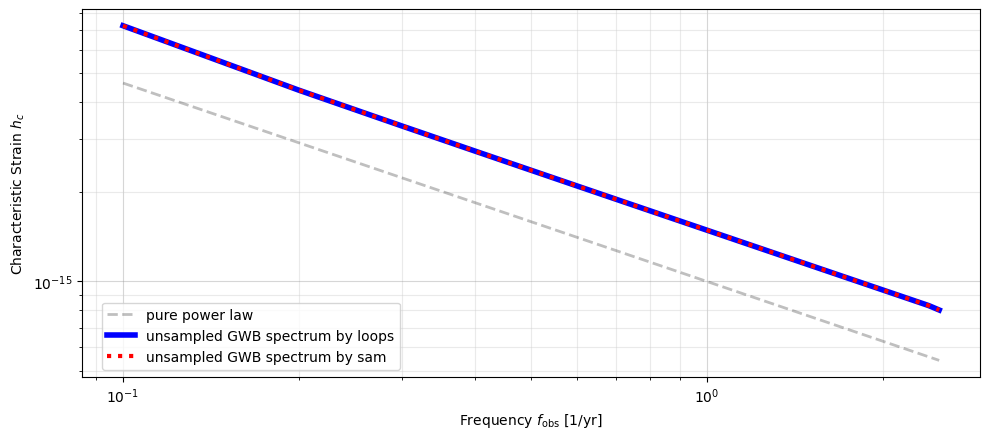

In [100]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# red: the sam method
ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum by loops')
ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dotted', label='unsampled GWB spectrum by sam')

# add legend
legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

### Plot multiple realizations vs frequency

In [49]:
def add_sampleGWB_to_plot(fig, ax, PLOT_GWB, LABEL, COLOR='b'):
    nsamp = PLOT_GWB.shape[1]
    ax.plot(xx, np.median(PLOT_GWB, axis=1), color=COLOR, label=LABEL)
    # plot contours at 50% and 98% confidence intervals
    for pp in [50, 98]:
        percs = pp / 2
        percs = [50 - percs, 50 + percs]
        ax.fill_between(xx, *np.percentile(PLOT_GWB, percs, axis=-1), alpha=0.25, color=COLOR)
    # Plot `nsamp` random spectra 
    
    idx = np.random.choice(PLOT_GWB.shape[1], nsamp, replace=False)
    ax.plot(xx, PLOT_GWB[:, idx], lw=1.0, alpha=0.5, color=COLOR, linestyle = 'dotted')

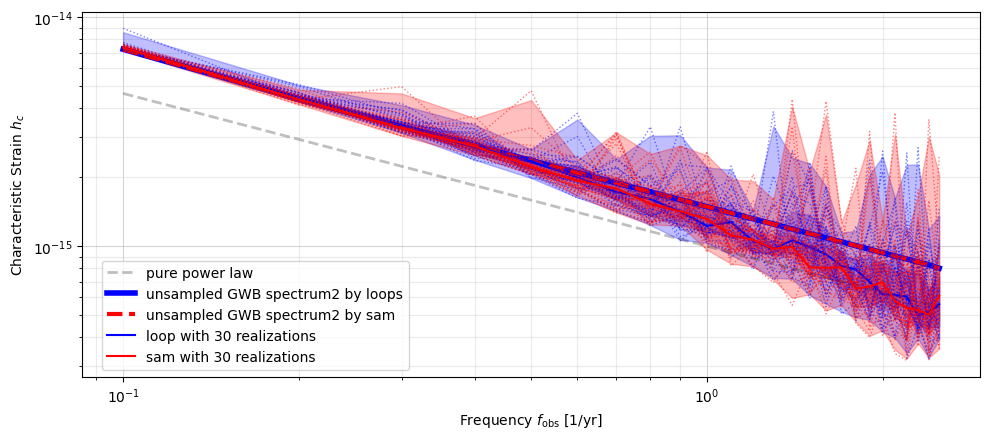

In [56]:
# Plot just this one realization
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# red: the sam method
ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum2 by loops')
ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dashed', label='unsampled GWB spectrum2 by sam')

# plot the model with Poisson sampling
add_sampleGWB_to_plot(fig, ax, hc_loop30_sum, LABEL='loop with 30 realizations', COLOR='b')
add_sampleGWB_to_plot(fig, ax, hc_sam30_sum, LABEL='sam with 30 realizations', COLOR='r')

# plot single realizations
# ax.plot(xx, hc_loop10_sum[:, 0], lw=4.0, alpha=0.6, color='green', linestyle = 'dotted',
#         label = 'loop realization')
# ax.plot(xx, hc_sam10_sum[:, 0], lw=4.0, alpha=0.6, color='purple', linestyle = 'dotted',
#         label = 'sam realization')


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

### Compare realization standard deviations

In [ ]:
std_loop = np.std(hc_loop30_sum, axis=1)
std_sam = np.std(hc_sam30_sum, axis=1)
print(np.max(np.abs(std_loop-std_sam)))
print(np.max(np.abs(std_loop/std_sam)))
print(std_loop.shape)

3.981042919646655e-16
2.8526409704512083
(25,)


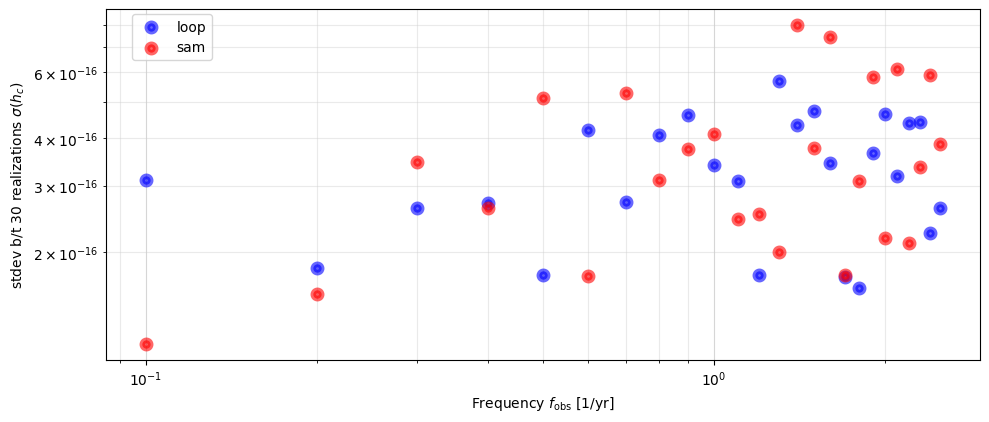

In [ ]:
# Plot the stdevs
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'stdev b/t 30 realizations $\sigma(h_c)$', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot single realizations
ax.scatter(xx, std_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop')
ax.scatter(xx, std_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam')


legend_gwb = ax.legend(bbox_to_anchor=(.13,.8), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

### Compare IQR

In [109]:
Q1_loop = np.percentile(hc_loop30_sum, 25, interpolation = 'midpoint')
Q3_loop = np.percentile(hc_loop30_sum, 75, interpolation = 'midpoint')
IQR_loop = Q3_loop - Q1_loop

C:\Users\emiga\AppData\Local\Temp\ipykernel_16596\1352987884.py:1: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1_loop = np.percentile(hc_loop30_sum, 25, interpolation = 'midpoint')
C:\Users\emiga\AppData\Local\Temp\ipykernel_16596\1352987884.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3_loop = np.percentile(hc_loop30_sum, 75, interpolation = 'midpoint')


In [119]:
# checking i know how to get IQR
test_arr = np.array([5, 2, 8, 4, 3, 6])
ordered_arr = np.sort(test_arr)
print(ordered_arr)
print(np.median(test_arr))
Q75, Q25 = np.percentile(test_arr, [75 ,25])
print(Q75,Q25)
print(Q75-Q25)

[2 3 4 5 6 8]
4.5
5.75 3.25
2.5


In [127]:
# applying to my data
Q75_loop, Q25_loop = np.percentile(hc_loop30_sum, [75 ,25], axis=1)
IQR_loop = Q75_loop-Q25_loop
Q75_sam, Q25_sam = np.percentile(hc_sam30_sum, [75 ,25], axis=1)
IQR_sam = Q75_sam-Q25_sam
print(np.max(np.abs(IQR_loop-IQR_sam)))
print(np.max(np.abs(IQR_loop/IQR_sam)))
print(np.min(np.abs(IQR_loop/IQR_sam)))
print(IQR_loop.shape)

3.5816459161507284e-16
2.1831418292749363
0.4363710325090581
(25,)


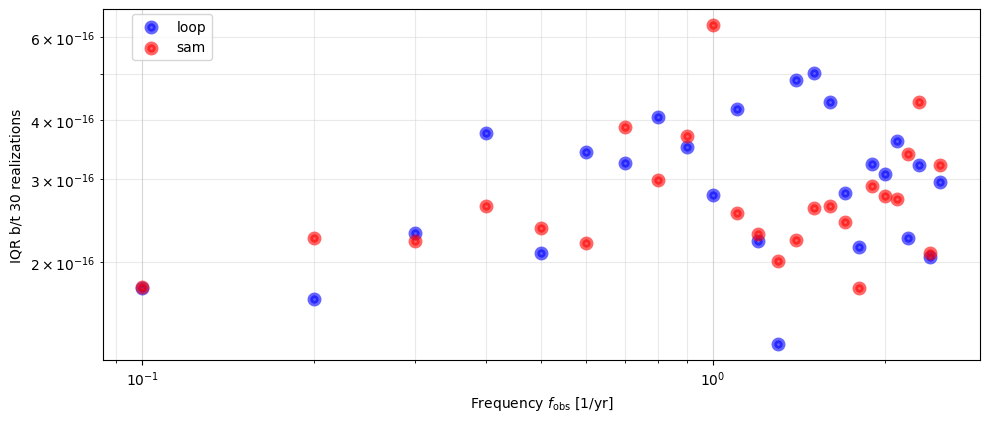

In [128]:
# Plot the IQRs
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'IQR b/t 30 realizations', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot single realizations
ax.scatter(xx, IQR_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop')
ax.scatter(xx, IQR_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam')


legend_gwb = ax.legend(bbox_to_anchor=(.13,.8), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

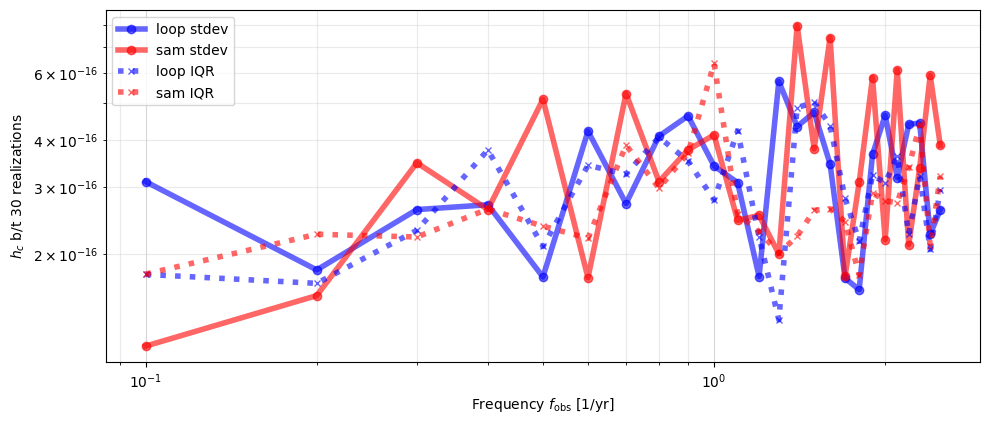

In [156]:
# IQR and Stdev 
# Plot the stdevs
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel=r'$h_c$ b/t 30 realizations', figsize=[10,4.5])

xx = fobs * YR

# # plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
# yy = 1e-15 * np.power(xx, -2.0/3.0)
# ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

ax.plot(xx, std_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop stdev', marker='o', linestyle = 'solid')
ax.plot(xx, std_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam stdev', marker='o', linestyle = 'solid')

ax.plot(xx, IQR_loop, lw=4.0, alpha=0.6, color='blue', 
        label = 'loop IQR', marker = 'x', ms=5, linestyle = 'dotted')
ax.plot(xx, IQR_sam, lw=4.0, alpha=0.6, color='red', 
        label = 'sam IQR', marker = 'x', ms = 5, linestyle='dotted')


legend_gwb = ax.legend(bbox_to_anchor=(.11,.93), bbox_transform=fig.transFigure, loc='upper left')
fig.tight_layout()

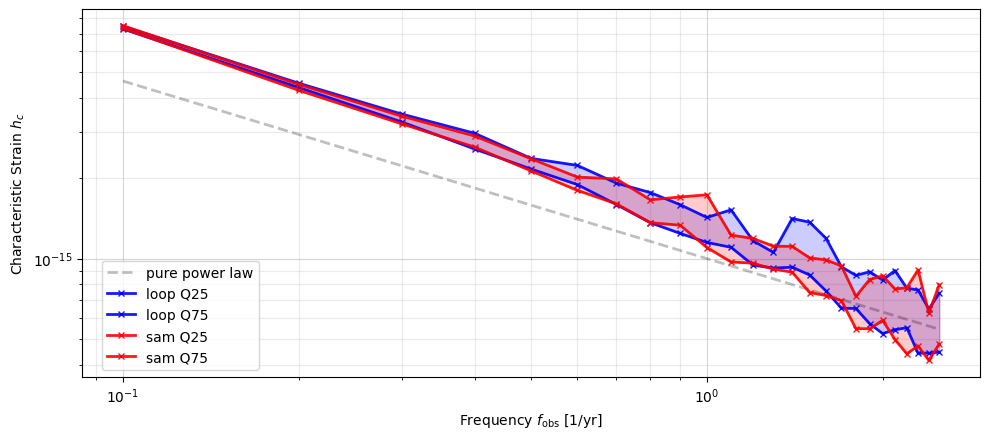

In [154]:
# Plot just this one realization
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# red: the sam method
# ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum2 by loops')
# ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dashed', label='unsampled GWB spectrum2 by sam')

# plot just 25th and 75th percentile
ax.plot(xx, Q25_loop, lw=2.0, alpha=.9, color='blue', 
        label = 'loop Q25', marker = 'x', ms=5, linestyle = 'solid')
ax.plot(xx, Q75_loop, lw=2.0, alpha=.9, color='blue', 
        label = 'loop Q75', marker = 'x', ms=5, linestyle = 'solid')
ax.fill_between(xx, Q25_loop, Q75_loop, alpha=0.2, color='blue')
   
ax.plot(xx, Q25_sam, lw=2.0, alpha=.9, color='red', 
        label = 'sam Q25', marker = 'x', ms=5, linestyle = 'solid')
ax.plot(xx, Q75_sam, lw=2.0, alpha=.9, color='red', 
        label = 'sam Q75', marker = 'x', ms=5, linestyle = 'solid')
ax.fill_between(xx, Q25_sam, Q75_sam, alpha=0.2, color='red')


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()